In [16]:
using Polynomials
using DSP
using Plots
using FFTW
pyplot()

include("ARMA_Generator.jl")
include("wiener_filter_scalar.jl")
include("SFbyCKMS.jl")

# Graph stuff
Nex = 2^10;
Theta = 2pi*(0:Nex-1)/(Nex-1);
Z = map(th -> exp(im*th),Theta);

## MA(3) signal with additive white noise

Choose signal process

In [17]:
w = [1, .4, .21]

3-element Array{Float64,1}:
 1.0 
 0.4 
 0.21

In [18]:
steps = 1*10^6
discard = 10^3
steps_tot = steps + discard

noise_sig = randn(steps_tot)
sig = conv(w,noise_sig)[discard + 1 : steps_tot];

noise_pred = randn(steps)
pred = sig .+ noise_pred;

Generate the $z$-spectra.

In [19]:
par = 30

Z_crossspect_sigpred_num = z_crossspect(sig, pred, par, win = "Par")

M = par
R_pred = autocov(pred,0:M)

#     Smoothing
LL = Int(floor(M/2))
lam1 = 1 .- 6*((0:LL)/M).^2 .+ 6*((0:LL)/M).^3
lam2 = 2*(1 .- (LL+1:M)/M).^3
lam = [lam1; lam2]

R_pred = R_pred.*lam
l = Scalar_CKMS_c(R_pred)

z_crossspect_sigpred_num = z_crossspect(sig, pred, par, win = "Par")
z_spect_pred_minus_num(z) = sum([l[i+1]z^(-i) for i = 0:M])
z_spect_pred_plus_num(z) = z_spect_pred_minus_num(z)'

S_sigpred_invS_plus_fft_num = fft(z_crossspect_sigpred_num.(Z)./z_spect_pred_plus_num.(Z))/Nex

Nexh = Int(floor(Nex/2))
S_sigpred_invS_plus_fft_plus_num = [S_sigpred_invS_plus_fft_num[1]; zeros(Nexh - 1); S_sigpred_invS_plus_fft_num[Nexh + 1:end]];


S_sigpred_invS_plus_plus_num = ifft(S_sigpred_invS_plus_fft_plus_num)*Nex


H_num = S_sigpred_invS_plus_plus_num./z_spect_pred_minus_num.(Z);


h_num_raw = fft(H_num)/Nex
h_num = [h_num_raw[1]; reverse(h_num_raw)[1:Nexh]]

513-element Array{Complex{Float64},1}:
       0.522993298909159 - 1.8699311101822748e-18im
      0.0993597975680013 - 0.00030483299751779064im
     0.02582266280806248 - 0.0001584478630605205im 
   -0.014580061938991602 + 0.00013419699876772965im
   0.0014069764579784177 - 1.72670656494752e-5im   
   0.0016518552668747261 - 2.534113014001134e-5im  
  0.00025766895354043494 - 4.743646492997656e-6im  
 -0.00016958435302390928 + 3.642507953137791e-6im  
   0.0007356217909252445 - 1.805850136051357e-5im  
  0.00012534314055215806 - 3.461811261330826e-6im  
    7.082653916830697e-5 - 2.1736130129188046e-6im 
  -0.0003618641363944098 + 1.2216676132669777e-5im 
 -0.00020448918617646555 + 7.531782716739489e-6im  
                         ⋮                         
   -3.309321090242751e-9 + 9.802376727013816e-8im  
  -3.0086692782501257e-9 + 9.803660140637459e-8im  
   -2.708043996660944e-9 + 9.805119729484511e-8im  
   -2.407431946329486e-9 + 9.806790503874805e-8im  
  -2.1068180363626035e-9 

Now to verify the preformance.

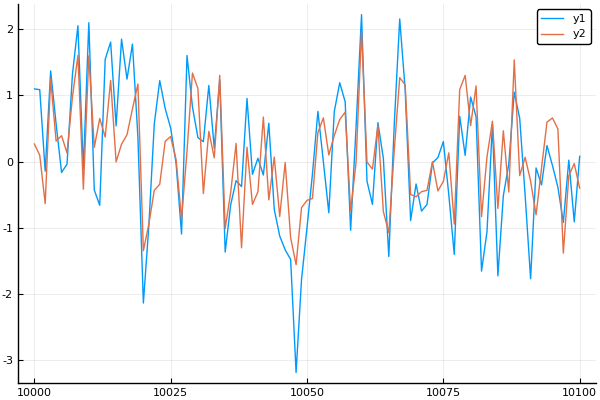

In [24]:
sig_hat = conv(real.(h_num),pred)[1:steps]

start = 10000
time = start : start + 100
plot(time,[sig[time] sig_hat[time]])

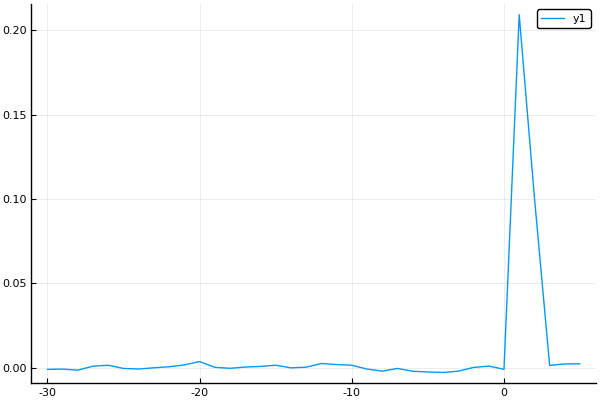

In [23]:
error = sig .-sig_hat
lags = -30:5
C = crosscov(error,pred,lags)
plot(lags, C)

